In [26]:
!pip install yfinance pandas matplotlib scikit-learn

In [27]:
# 2. 데이터 불러오기 및 정제
# Yahoo Finance API를 사용해 삼성전자 주가 데이터를 다운로드하고 필요한 부분만 정제합니다.
import yfinance as yf  # 금융 데이터 다운로드 및 Yahoo Finance API 사용
import pandas as pd  # 데이터 조작 및 분석을 위한 DataFrame 처리
import numpy as np  # 수학적 연산과 배열 조작을 위한 라이브러리
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화를 위한 스케일링 도구
import torch  # PyTorch를 사용한 신경망 구현 및 연산
from torch.utils.data import DataLoader, TensorDataset  # PyTorch 데이터 로딩 및 텐서 처리
import torch.nn as nn  # PyTorch의 신경망 모듈 정의 및 레이어 구성
import matplotlib.pyplot as plt  # 데이터 시각화와 플롯 생성 도구

In [28]:
# ticker = "005930.KS"  # 삼성전자 주식의 한국 거래소 코드 설정
# data = yf.download(ticker, start="2018-01-01", end="2024-11-05")  # 주식 데이터를 다운로드, end 기간에 원하는 기간으로 변경해서 사용 가능
# 1. 티커 설정 및 다운로드
ticker = "TSLA"  # 삼성전자 (한국 거래소 코드)
data = yf.download(ticker, start="2018-01-01", end="2024-11-05")

# 2. CSV 파일로 저장
csv_filename = "./samsung_stock_2018_2024.csv"
# data.to_csv(csv_filename)
# CSV 불러올 때 컬럼명을 직접 설정
# 데이터 불러오기 (첫 번째 열을 날짜 인덱스로 설정)
# data = pd.read_csv(csv_filename, index_col=0, parse_dates=True)

# 컬럼명 공백 제거 (혹시 있을 경우 대비)
# data.columns = data.columns.str.strip()

# 컬럼명 확인 (디버깅용)
# print("Columns in CSV:", data.columns)

# 필요한 컬럼 선택
data = data[['Open', 'High', 'Low', 'Close']]

# 데이터 확인
print(data.head())
# 받아오는 전체 데이터 값 종류: Open(시가), High(고가), Low(저가), Close(종가), Adj Close(조정 종가), Volume(거래량)
data = data[['Open', 'High', 'Low', 'Close']]  # 특정 열만 추출(시가, 고가, 저가, 종가), data 모양 예시: [행 개수, 4] (예: [1500, 4])

scaler = MinMaxScaler()  # 데이터 정규화를 위한 스케일러
data_scaled = scaler.fit_transform(data)  # 데이터 정규화 수행, data_scaled 모양 예시: [행 개수, 4] (예: [1500, 4])

X = []  # 입력 데이터 배열 초기화
y = []  # 타겟 데이터 배열 초기화
window_size = 60  # 과거 60일 데이터를 기반으로 예측할 윈도우 크기

for i in range(window_size, len(data_scaled)):
  X.append(data_scaled[i-window_size:i, :])  # 윈도우 크기만큼의 시계열 데이터 추가 (시가, 고가, 저가, 종가), X의 각 항목 모양 예시: [60, 4]
  y.append(data_scaled[i, 3])  # 종가(Close) 예측을 위한 타겟 데이터 추가, y의 각 항목은 단일 값 (예: 0.85)

X = np.array(X)  # 입력 데이터 배열 변환, X 모양 예시: [전체 데이터 수 - window_size, 60, 4]
y = np.array(y)  # 타겟 데이터 배열 변환, y 모양 예시: [전체 데이터 수 - window_size]


[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close
Ticker           TSLA       TSLA       TSLA       TSLA
Date                                                  
2018-01-02  20.799999  21.474001  20.733334  21.368668
2018-01-03  21.400000  21.683332  21.036667  21.150000
2018-01-04  20.858000  21.236668  20.378668  20.974667
2018-01-05  21.108000  21.149332  20.799999  21.105333
2018-01-08  21.066668  22.468000  21.033333  22.427334


In [29]:
# 3. RNN 모델 정의

# RNN을 사용하여 삼성전자 주가를 예측하는 모델을 정의합니다.

# PyTorch의 신경망 모듈을 상속받아 주식 예측을 위한 RNN 모델을 정의하는 클래스
class StockRNN(nn.Module):
    # 모델의 초기화 함수로 입력, 은닉, 출력 크기를 정의
    def __init__(self, input_size, hidden_size, output_size):
        super(StockRNN, self).__init__()  # 부모 클래스의 초기화 메서드 호출
	 # 시계열 데이터를 처리하기 위한 RNN 레이어
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

	 # 은닉 상태를 최종 예측 값으로 변환하는 선형 레이어
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):  # 모델의 순전파 정의
        out, _ = self.rnn(x)  # 입력 시퀀스를 RNN으로 처리하여 출력과 은닉 상태 반환
	# 마지막 시점의 출력을 선형 레이어로 변환하여 예측값 반환
        out = self.fc(out[:, -1, :])
        return out

In [30]:
# 4. 학습 데이터 준비 및 훈련

import os  # 운영 체제와 상호 작용하기 위한 모듈
# Google Colab에서 Google Drive를 마운트하기 위한 모듈
# from google.colab import drive
# drive.mount('/content/drive')  # Google Drive를 '/content/drive' 경로에 마운트

train_size = int(0.8 * len(X))  # 데이터셋의 80%를 훈련용으로 설정
X_train, X_test = X[:train_size], X[train_size:]  # 입력 데이터 훈련 및 테스트 분할, X_train 모양 예시: [배치 크기, 60, 4], X_test 모양 예시: [배치 크기, 60, 4]
y_train, y_test = y[:train_size], y[train_size:]  # 타겟 데이터 훈련 및 테스트 분할, y_train 모양 예시: [배치 크기], y_test 모양 예시: [배치 크기]

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))  # 훈련 데이터를 PyTorch 텐서 데이터셋으로 변환
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))  # 테스트 데이터를 PyTorch 텐서 데이터셋으로 변환
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # 훈련 데이터를 배치 단위로 로딩하기 위한 DataLoader 생성
test_loader = DataLoader(test_data, batch_size=32)  # 테스트 데이터를 배치 단위로 로딩하기 위한 DataLoader 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 가용 여부에 따라 학습 장치 설정
model = StockRNN(input_size=4, hidden_size=64, output_size=1).to(device)
criterion = nn.MSELoss()  # 손실 함수로 평균 제곱 오차 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화 알고리즘으로 모델의 파라미터를 최적화

# 모델 학습

epochs = 50  # 학습을 위한 에포크 수 설정
train_losses = []  # 훈련 손실을 저장할 리스트
test_losses = []  # 테스트 손실을 저장할 리스트

for epoch in range(epochs):  # 지정된 에포크 수만큼 반복
   model.train()  # 모델을 학습 모드로 설정
   train_loss = 0  # 훈련 손실 초기화
   for X_batch, y_batch in train_loader:  # 훈련 데이터 배치 처리
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 입력 데이터를 장치에 할당 (CPU/GPU), X_batch 모양 예시: [32, 60, 4], y_batch 모양 예시: [32]
      optimizer.zero_grad()  # 이전 그래디언트 초기화
      predictions = model(X_batch)  # 모델의 예측값 계산, predictions 모양 예시: [32, 1]
      loss = criterion(predictions.squeeze(), y_batch)  # 손실 계산, loss는 스칼라 값 예시 (예: 0.045)
      loss.backward()  # 그래디언트 역전파
      optimizer.step()  # 모델의 파라미터 업데이트
      train_loss += loss.item()  # 배치 손실을 누적

   train_loss /= len(train_loader)  # 훈련 손실 평균 계산
   train_losses.append(train_loss)  # 훈련 손실을 리스트에 추가

   model.eval()  # 모델을 평가 모드로 설정
   test_loss = 0  # 테스트 손실 초기화
   with torch.no_grad():  # 그래디언트 비활성화
      for X_batch, y_batch in test_loader:  # 테스트 데이터 배치 처리
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 입력 데이터를 장치에 할당, X_batch 모양 예시: [32, 60, 4], y_batch 모양 예시: [32]
          predictions = model(X_batch)  # 모델의 예측값 계산, predictions 모양 예시: [32, 1]
          loss = criterion(predictions.squeeze(), y_batch)  # 손실 계산, loss는 스칼라 값 예시 (예: 0.032)
          test_loss += loss.item()  # 배치 손실을 누적

   test_loss /= len(test_loader)  # 테스트 손실 평균 계산
   test_losses.append(test_loss)  # 테스트 손실을 리스트에 추가

   print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")  # 에포크 진행 상황 출력

# 저장 위치
model_weight_save_path = "./"
# 모델 저장
torch.save(model.state_dict(), os.path.join(model_weight_save_path, 'tesla_250321.pth'))  # 모델 가중치 저장
torch.save(scaler, os.path.join(model_weight_save_path, 'tesla_scaler_250321.pth'))  # 데이터 스케일러 저장


Epoch 1/50, Train Loss: 0.0203, Test Loss: 0.0007
Epoch 2/50, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 3/50, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 4/50, Train Loss: 0.0005, Test Loss: 0.0008
Epoch 5/50, Train Loss: 0.0006, Test Loss: 0.0010
Epoch 6/50, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 7/50, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 8/50, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 9/50, Train Loss: 0.0005, Test Loss: 0.0009
Epoch 10/50, Train Loss: 0.0006, Test Loss: 0.0006
Epoch 11/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 12/50, Train Loss: 0.0006, Test Loss: 0.0010
Epoch 13/50, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 14/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 15/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 16/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 17/50, Train Loss: 0.0004, Test Loss: 0.0006
Epoch 18/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 19/50, Train Loss: 0.0005, Test Loss: 0.0005
Epoch 20/50, Train Loss: 0.0004, Test Lo

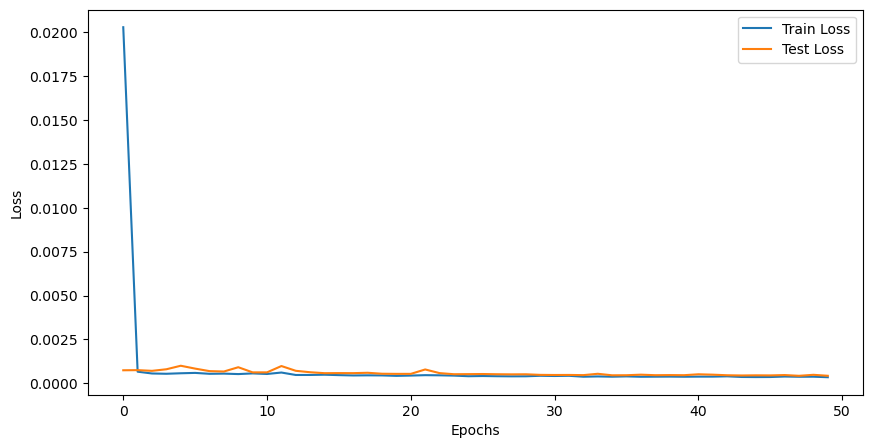

In [31]:
# 5. 손실 값 그래프 시각화

plt.figure(figsize=(10, 5))  # 그래프 크기를 10x5로 설정
plt.plot(train_losses, label="Train Loss")  # 훈련 손실을 그래프로 그리기
plt.plot(test_losses, label="Test Loss")  # 테스트 손실을 그래프로 그리기
plt.xlabel("Epochs")  # x축 레이블 설정
plt.ylabel("Loss")  # y축 레이블 설정
plt.legend()  # 그래프에 범례 추가
plt.show()  # 그래프를 화면에 표시

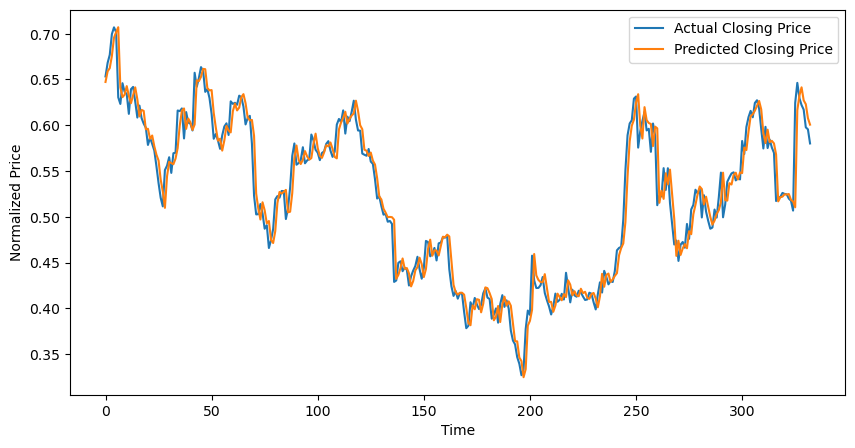

In [32]:
# 6. 예측값 생성 및 시각화

# 훈련된 모델을 이용해 테스트 데이터에 대한 예측을 수행하고, 예측 결과를 시각화합니다.

# 테스트 데이터에 대한 예측
model.eval()  # 모델을 평가 모드로 전환하여 드롭아웃 및 배치 정규화를 비활성화합니다.
predictions = []  # 예측된 값을 저장할 리스트를 초기화합니다.
actual = []  # 실제 값을 저장할 리스트를 초기화합니다.
with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리 사용량을 줄입니다.
  for X_batch, y_batch in test_loader:  # 테스트 데이터를 배치 단위로 반복합니다.
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 데이터를 지정한 장치로 이동시킵니다.
      pred = model(X_batch).squeeze()  # 모델을 통해 예측값을 얻고 불필요한 차원을 제거합니다.
      predictions.extend(pred.cpu().numpy())  # 예측값을 CPU로 이동 후 리스트에 추가합니다.
      actual.extend(y_batch.cpu().numpy())  # 실제 값을 CPU로 이동 후 리스트에 추가합니다.
plt.figure(figsize=(10, 5))  # 시각화할 그래프 크기를 설정합니다.
plt.plot(actual, label="Actual Closing Price")  # 실제 값의 변화를 선 그래프로 그립니다.
plt.plot(predictions, label="Predicted Closing Price")  # 예측 값의 변화를 선 그래프로 그립니다.
plt.xlabel("Time")  # x축 라벨을 설정합니다.
plt.ylabel("Normalized Price")  # y축 라벨을 설정합니다.
plt.legend()  # 그래프의 범례를 표시합니다.
plt.show()  # 그래프를 화면에 표시합니다.

In [33]:
# 7. 샘플 입력값으로 다음날 예측값 구하기

# 마지막 60일의 데이터를 입력값으로 사용하여 다음날 주가 예측
# 임의의 입력값을 통해 다음날 주가를 예측합니다.
# window_size = 60
last_60_days = data_scaled[-window_size:]  # 데이터의 마지막 60일을 선택하여 입력값으로 사용합니다.
last_60_days = np.expand_dims(last_60_days, axis=0)  # 모델 입력에 적합하도록 차원을 추가합니다.
last_60_days_tensor = torch.tensor(last_60_days, dtype=torch.float32).to(device)  # 데이터를 텐서로 변환하고 장치에 맞게 전송합니다.

model.eval()  # 모델을 평가 모드로 전환하여 예측을 수행합니다.
with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리 및 연산량을 줄입니다.
   predicted_price = model(last_60_days_tensor).item()  # 모델을 통해 다음날 종가를 예측합니다.
   predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0, 3]  # 종가를 반정규화하여 원래 값으로 변환합니다.

print(f"다음날 예측 종가: {predicted_price:.2f} 원")  # 예측된 종가를 출력합니다.
# 다음날 예측 종가: 58678.54 원

다음날 예측 종가: 243.78 원


#### 코드 확인 연습장 부분####

In [34]:

# 예시 입력 데이터 (배치 크기 3, 시퀀스 길이 10, 입력 크기 4)
x = torch.randn(3, 10, 4)  # (배치 크기, 시퀀스 길이, 입력 크기)
print(x)
print("==================================================")
print(x[:,-1,:])
print((x[:,-1,:]).shape)

tensor([[[ 0.8703,  0.2883, -0.2949,  0.4663],
         [ 1.0306, -0.8789,  1.8814,  0.4645],
         [ 1.5783, -0.6676, -0.1150, -0.7656],
         [ 1.6387,  0.0212,  1.6471,  0.7371],
         [-0.2830, -0.4324,  1.0329, -1.8731],
         [-0.7734, -0.0167, -0.4482,  1.9288],
         [-1.2829, -0.9947,  0.0188, -0.8908],
         [-1.4514, -0.0489, -0.1452,  0.1518],
         [-1.2650,  0.3290, -0.3226, -0.0242],
         [ 1.2815,  0.5002, -0.5495, -0.7399]],

        [[ 1.5219,  0.4565,  1.1176,  0.6057],
         [-0.6665, -1.0393, -1.5448,  2.5991],
         [ 1.2007,  0.5025,  1.7947, -0.5287],
         [-0.6922, -0.1922,  0.4879, -0.5396],
         [ 0.0667, -0.9466, -0.4106,  1.9698],
         [ 1.1460, -0.9692, -0.1499, -1.9997],
         [ 0.6775, -0.4406,  0.4558,  1.7496],
         [-1.7721, -1.8621, -0.9073, -0.1977],
         [ 1.0930, -0.9431,  1.1459, -1.5294],
         [ 0.2528,  0.2218,  1.2031,  0.3548]],

        [[-0.6622, -0.4980, -1.3550,  0.7904],
         

In [35]:
import torch
import torch.nn as nn

# RNN 모델 정의
class StockPredictorRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=50, num_layers=2, output_size=1):
        super(StockPredictorRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 은닉 상태에 대해 선형 변환 수행
        return out

# 입력 텐서 예제: (배치 크기, 시퀀스 길이, 입력 크기)
x = torch.randn(3, 10, 4)  # (3, 10, 4)

# 모델 초기화 및 예측 수행
model = StockPredictorRNN(input_size=4, hidden_size=50, num_layers=2, output_size=1)
output = model(x)

# 출력 확인
print("입력 텐서 크기:", x.shape)  # 입력 텐서 크기: torch.Size([3, 10, 4])
print("RNN 출력 텐서 크기 (out):", model.rnn(x, torch.zeros(model.num_layers, x.size(0), model.hidden_size))[0].shape)  # RNN 전체 출력 크기
print("마지막 타임스텝 은닉 상태 (out[:, -1, :]):", model.rnn(x, torch.zeros(model.num_layers, x.size(0), model.hidden_size))[0][:, -1, :].shape)  # 마지막 타임스텝 은닉 상태 크기
print("최종 출력 텐서 크기:", output.shape)  # 최종 출력 텐서 크기


입력 텐서 크기: torch.Size([3, 10, 4])
RNN 출력 텐서 크기 (out): torch.Size([3, 10, 50])
마지막 타임스텝 은닉 상태 (out[:, -1, :]): torch.Size([3, 50])
최종 출력 텐서 크기: torch.Size([3, 1])
